#  Классификация изображений с помощью сверточных нейронных сетей

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы: 
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann 
* https://pytorch.org/docs/stable/nn.html#convolution-layers
* https://pytorch.org/vision/0.16/transforms.html#v2-api-reference-recommended
* https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
* https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html
* https://kozodoi.me/blog/20210308/compute-image-stats
* https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.matshow.html

## Задачи для совместного разбора

1\. Рассмотрите основные возможности по созданию датасетов из `torchvision` и примеры работы основных слоев для создания сверточных нейронных сетей для анализа изображений.

In [1]:
import torchvision
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  #[-1, 1]
])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform
)

C:\Users\Kq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
100%|██████████| 170M/170M [00:38<00:00, 4.41MB/s] 


in_channels  Число входных каналов (RGB: 3)
out_channels  Число фильтров

In [ ]:
import torch.nn as nn

conv_layer = nn.Conv2d(
    in_channels=3,   
    out_channels=16, 
    kernel_size=3,    
    stride=1,       
    padding=1        
)

In [ ]:
pool_layer = nn.MaxPool2d(kernel_size=2, stride=2)
activation = nn.ReLU()
linear_layer = nn.Linear(in_features=1024, out_features=10)
dropout = nn.Dropout(p=0.5)

2\. Реализуйте типовую архитектуру CNN для классификации изображений.

In [ ]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 256)  
        self.fc2 = nn.Linear(256, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)  
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN()
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)


## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Создайте датасет `CatBreeds` на основе данных из архива `cat_breeds_4.zip`. Используя преобразования `torchvision`, приведите картинки к размеру 300х300 и нормализуйте значения интенсивности пикселей (рассчитайте статистику для нормализации отдельно). Выведите на экран количество картинок в датасете,  размер одной картинки, количество уникальных классов. Разбейте датасет на обучающее и тестовое множество в соотношении 80 на 20%.

- [ ] Проверено на семинаре

In [ ]:
import os
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from PIL import Image
import numpy as np


class CatBreedsDataset(datasets.ImageFolder):
    def __init__(self, root, transform=None):

        temp_transform = transforms.Compose([
            transforms.Resize((300, 300)),  
            transforms.ToTensor()
        ])
        super().__init__(root=root, transform=temp_transform)
        
      
        self.calculate_mean_std()
        
        
        self.transform = transform
        
    def calculate_mean_std(self):
        pixel_values = []
        for img_path, _ in self.samples:
            img = Image.open(img_path).convert('RGB')
            img = transforms.Resize((300, 300))(img)  
            img = transforms.ToTensor()(img)
            pixel_values.append(img)
            

        pixel_values = torch.stack(pixel_values, dim=0)
        self.mean = torch.mean(pixel_values, dim=(0, 2, 3))
        self.std = torch.std(pixel_values, dim=(0, 2, 3))

data_dir = 'cat_breeds_4'


temp_dataset = CatBreedsDataset(root=data_dir, transform=None)


transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=temp_dataset.mean, std=temp_dataset.std)
])


dataset = CatBreedsDataset(root=data_dir, transform=transform)


print(f"Всего изображений: {len(dataset)}")
print(f"Размер изображения: {dataset[0][0].shape}") 
print(f"Количество классов: {len(dataset.classes)}")
print(f"Имена классов: {dataset.classes}")
print(f"Среднее значение пикселей: {dataset.mean}")
print(f"Стандартное отклонение: {dataset.std}")


train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(f"\nОбучающая выборка: {len(train_dataset)} изображений")
print(f"Тестовая выборка: {len(test_dataset)} изображений")


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Всего изображений: 4000
Размер изображения: torch.Size([3, 300, 300])
Количество классов: 4
Имена классов: ['American Shorthair', 'Persian', 'Russian Blue', 'Tiger']
Среднее значение пикселей: tensor([0.5000, 0.4514, 0.4066])
Стандартное отклонение: tensor([0.2644, 0.2585, 0.2573])

Обучающая выборка: 3200 изображений
Тестовая выборка: 800 изображений


<p class="task" id="2"></p>

2\. Решите задачу классификации на основе датасета из предыдущего задания, не используя сверточные слои. Постройте график изменения значения функции потерь на обучающем множестве в зависимости от номера эпохи, графики изменения метрики accuracy на обучающем и тестовом множестве в зависимости от эпохи. Выведите на экран итоговое значение метрики accuracy на обучающем и тестовом множестве. Выведите на экран количество параметров модели.   

- [ ] Проверено на семинаре

Всего параметров модели: 138,372,868
Эпоха 1/20, Loss: 23.8472, Train Acc: 0.2787, Test Acc: 0.3013
Эпоха 2/20, Loss: 1.9458, Train Acc: 0.2969, Test Acc: 0.2900
Эпоха 3/20, Loss: 1.5629, Train Acc: 0.2834, Test Acc: 0.3063
Эпоха 4/20, Loss: 1.4463, Train Acc: 0.2828, Test Acc: 0.3025
Эпоха 5/20, Loss: 1.4168, Train Acc: 0.2800, Test Acc: 0.2963
Эпоха 6/20, Loss: 1.4130, Train Acc: 0.2938, Test Acc: 0.2737
Эпоха 7/20, Loss: 1.4258, Train Acc: 0.2897, Test Acc: 0.2737
Эпоха 8/20, Loss: 1.3965, Train Acc: 0.2994, Test Acc: 0.2725
Эпоха 9/20, Loss: 1.4228, Train Acc: 0.2847, Test Acc: 0.2737
Эпоха 10/20, Loss: 1.3957, Train Acc: 0.2978, Test Acc: 0.2600
Эпоха 11/20, Loss: 1.3889, Train Acc: 0.2978, Test Acc: 0.2650
Эпоха 12/20, Loss: 1.3986, Train Acc: 0.2853, Test Acc: 0.2812
Эпоха 13/20, Loss: 1.3950, Train Acc: 0.2913, Test Acc: 0.2888
Эпоха 14/20, Loss: 1.3880, Train Acc: 0.2963, Test Acc: 0.2462
Эпоха 15/20, Loss: 1.4076, Train Acc: 0.2672, Test Acc: 0.2600
Эпоха 16/20, Loss: 1.3800,

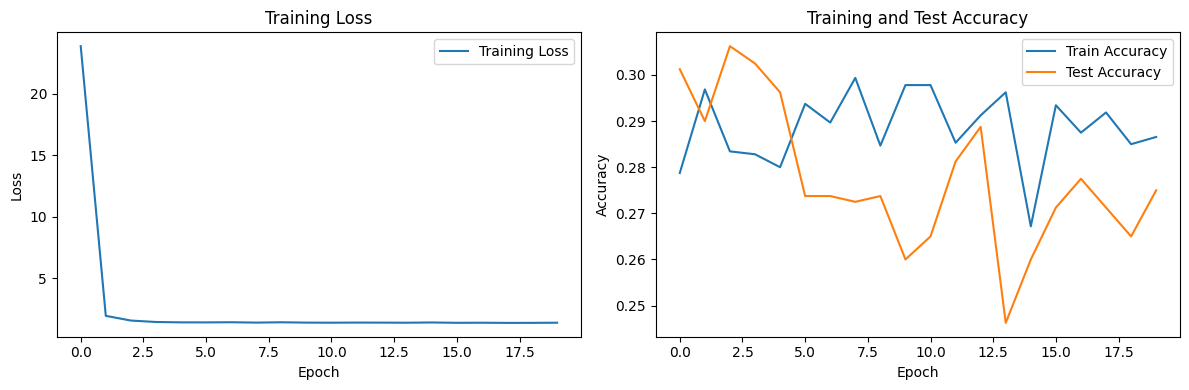

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score


class CatBreedClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)  
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


input_size = 3 * 300 * 300  
num_classes = 4
model = CatBreedClassifier(input_size, num_classes)


total_params = sum(p.numel() for p in model.parameters())
print(f"Всего параметров модели: {total_params:,}")


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 20
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
  
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct_train / total_train
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    

    model.eval()
    correct_test = 0
    total_test = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    
    test_acc = correct_test / total_test
    test_accuracies.append(test_acc)
    
    print(f"Эпоха {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Test Acc: {test_acc:.4f}")


final_train_acc = train_accuracies[-1]
final_test_acc = test_accuracies[-1]
print(f"\nИтоговая точность на обучающем множестве: {final_train_acc:.4f}")
print(f"Итоговая точность на тестовом множестве: {final_test_acc:.4f}")


plt.figure(figsize=(12, 4))


plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

<p class="task" id="3"></p>

3\. Напишите функцию, которая выбирает несколько изображений из переданного набора данных и выводит их на экран в виде сетки с указанием над ними названия правильного класса и класса, предсказанного моделью. Воспользовавшись данной функцией, выведите прогнозы итоговой модели из предыдущей задачи по 6 случайным картинкам.

```
def show_examples(model, dataset, k=6):
    pass
```

- [ ] Проверено на семинаре

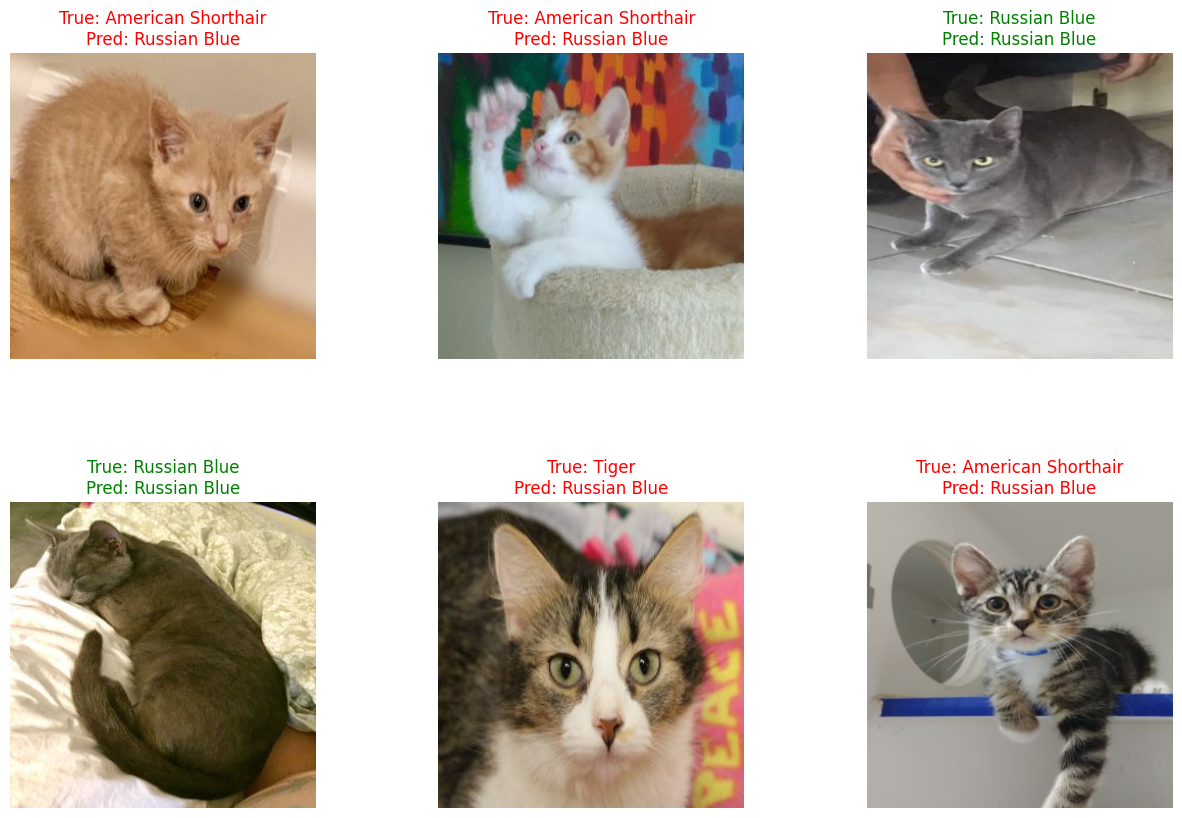

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

def show_examples(model, dataset, k=6):
 
    indices = random.sample(range(len(dataset)), k)
    

    plt.figure(figsize=(15, 10))
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
    for i, idx in enumerate(indices):

        image, true_label = dataset[idx]
        

        with torch.no_grad():
            output = model(image.unsqueeze(0))
            _, predicted = torch.max(output, 1)
            predicted_label = predicted.item()
        
 
        img = image.numpy().transpose((1, 2, 0))
        img = img * np.array(dataset.std) + np.array(dataset.mean)  
        img = np.clip(img, 0, 1)
        
   
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.axis('off')
        
        # Формируем заголовок
        true_class = dataset.classes[true_label]
        predicted_class = dataset.classes[predicted_label]
        color = 'green' if true_label == predicted_label else 'red'
        
        plt.title(f"True: {true_class}\nPred: {predicted_class}", color=color)
    
    plt.show()


show_examples(model, dataset)

<p class="task" id="4"></p>

4\. Решите задачу классификации на основе датасета из первого задания, используя сверточные слои. Постройте график изменения значения функции потерь на обучающем множестве в зависимости от номера эпохи, графики изменения метрики accuracy на обучающем и тестовом множестве в зависимости от эпохи. Выведите на экран итоговое значение метрики accuracy на обучающем и тестовом множестве. Выведите на экран количество параметров модели. Воспользовавшись функцией из предыдущего задания, выведите прогнозы итоговой модели по 6 случайным картинкам.

- [ ] Проверено на семинаре

Всего параметров модели: 89,814,596
Эпоха 1/5, Loss: 1.5561, Train Acc: 0.2753, Test Acc: 0.2775
Эпоха 2/5, Loss: 1.3869, Train Acc: 0.2444, Test Acc: 0.2775
Эпоха 3/5, Loss: 1.3865, Train Acc: 0.2481, Test Acc: 0.2225
Эпоха 4/5, Loss: 1.3864, Train Acc: 0.2550, Test Acc: 0.2225
Эпоха 5/5, Loss: 1.3864, Train Acc: 0.2572, Test Acc: 0.2225

Итоговая точность на обучающем множестве: 0.2572
Итоговая точность на тестовом множестве: 0.2225


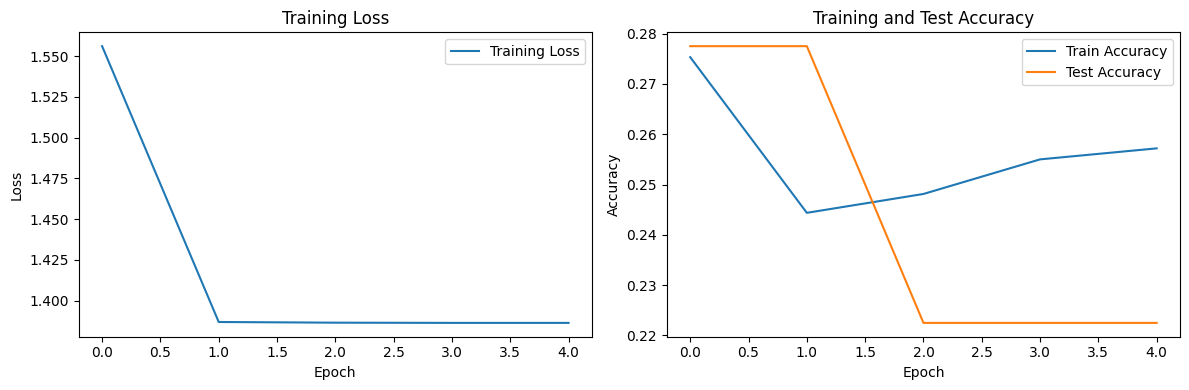

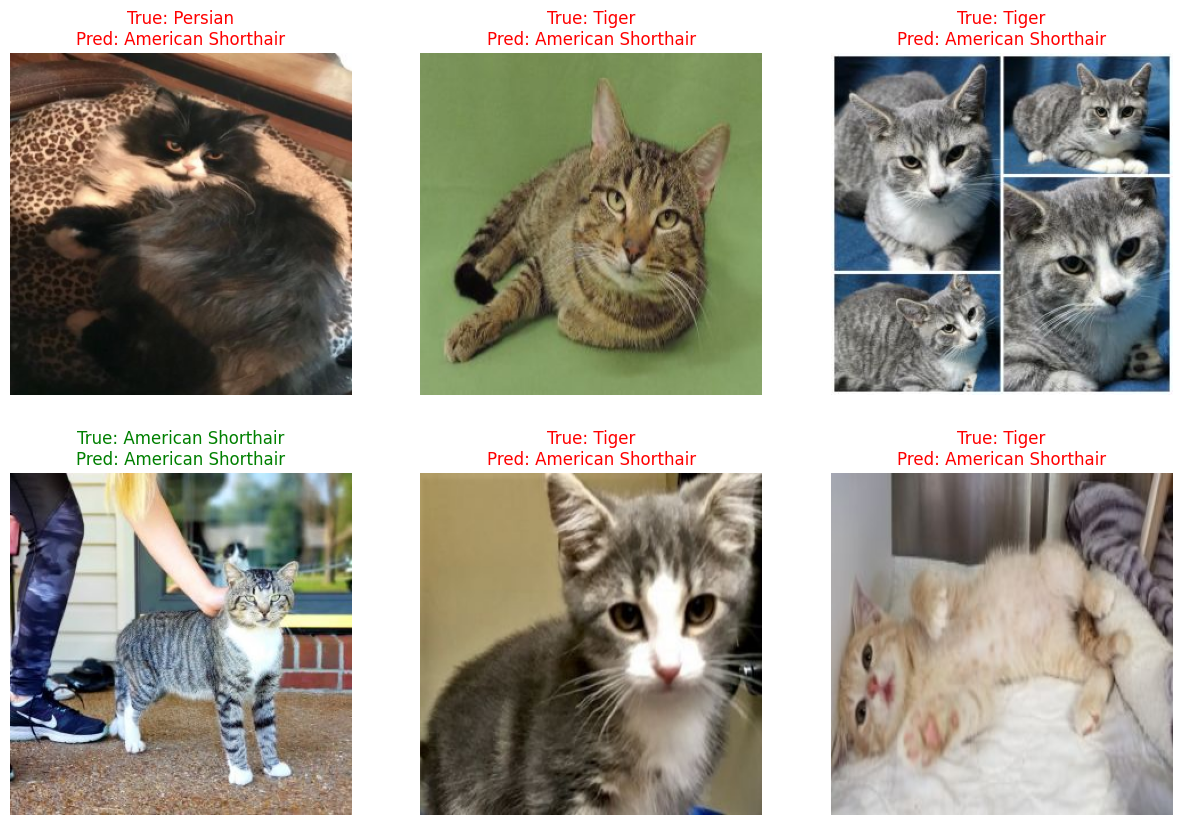

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


class CatBreedCNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 37 * 37, 512),  
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


model = CatBreedCNN(num_classes=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


total_params = sum(p.numel() for p in model.parameters())
print(f"Всего параметров модели: {total_params:,}")


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 5
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):

    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct_train / total_train
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    

    model.eval()
    correct_test = 0
    total_test = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    
    test_acc = correct_test / total_test
    test_accuracies.append(test_acc)
    
    print(f"Эпоха {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Test Acc: {test_acc:.4f}")


final_train_acc = train_accuracies[-1]
final_test_acc = test_accuracies[-1]
print(f"\nИтоговая точность на обучающем множестве: {final_train_acc:.4f}")
print(f"Итоговая точность на тестовом множестве: {final_test_acc:.4f}")


plt.figure(figsize=(12, 4))


plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


def show_examples(model, dataset, k=6):
    model.eval()
    indices = random.sample(range(len(dataset)), k)
    
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(indices):
        image, true_label = dataset[idx]
        image = image.unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(image)
            _, predicted = torch.max(output, 1)
            predicted_label = predicted.item()
        
        image = image.squeeze().cpu()
        img = image.numpy().transpose((1, 2, 0))
        img = img * np.array(dataset.std) + np.array(dataset.mean)
        img = np.clip(img, 0, 1)
        
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.axis('off')
        
        true_class = dataset.classes[true_label]
        predicted_class = dataset.classes[predicted_label]
        color = 'green' if true_label == predicted_label else 'red'
        
        plt.title(f"True: {true_class}\nPred: {predicted_class}", color=color)
    
    plt.show()

show_examples(model, dataset)

<p class="task" id="5"></p>

5\. Проанализируйте обученную в предыдущей задаче модель, исследовав обученные ядра сверточных слоев. Выберите одно изображение из тестового набора данных и пропустите через первый сверточный слой модели. Визуализируйте полученные карты признаков.

- [ ] Проверено на семинаре

Размерность ядер первого сверточного слоя: (32, 3, 3, 3)


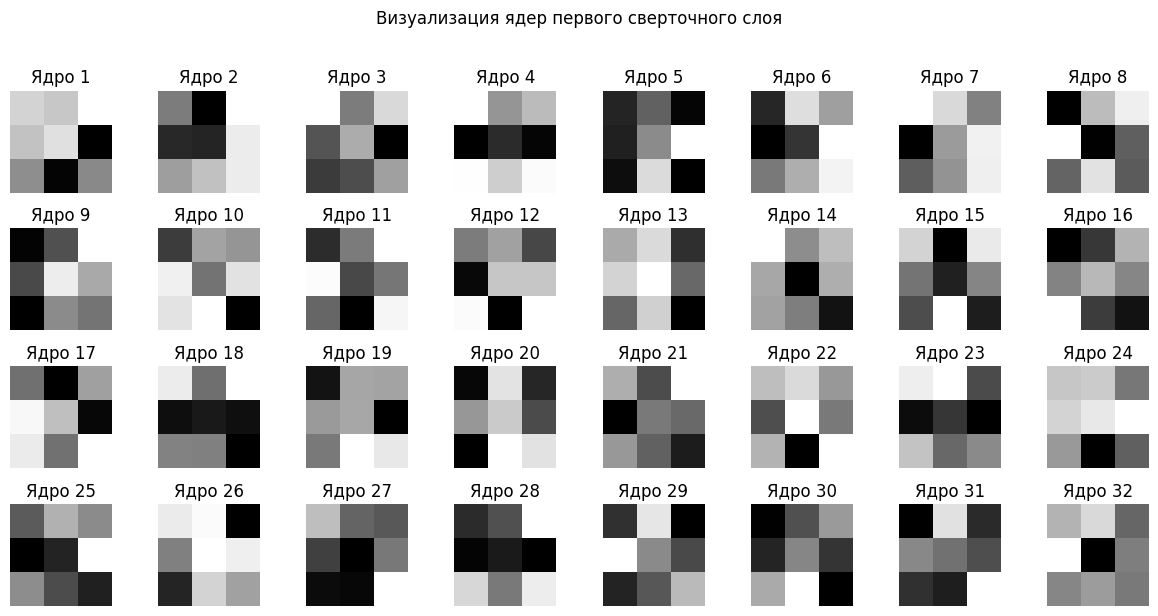

Размерность карт признаков: (32, 300, 300)


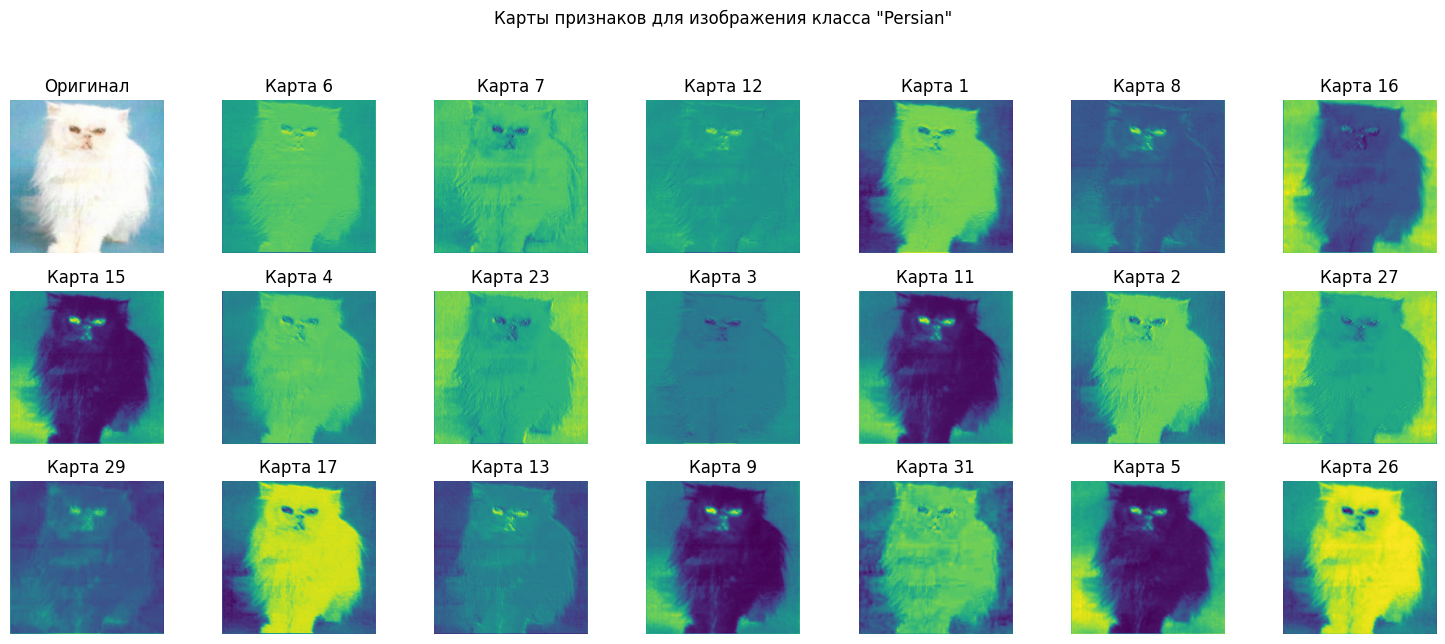

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


test_image, test_label = next(iter(test_loader))
single_image = test_image[0].unsqueeze(0).to(device)  
true_class = dataset.classes[test_label[0]]


first_conv = model.features[0]
weights = first_conv.weight.data.cpu().numpy()
print(f"Размерность ядер первого сверточного слоя: {weights.shape}")  


plt.figure(figsize=(12, 6))
plt.suptitle('Визуализация ядер первого сверточного слоя', y=1.02)

for i in range(32):  
    plt.subplot(4, 8, i+1)
    kernel = weights[i, 0]  
    plt.imshow(kernel, cmap='gray')
    plt.axis('off')
    plt.title(f'Ядро {i+1}')

plt.tight_layout()
plt.show()


def get_feature_maps(model, image):

    features = []
    def hook(module, input, output):
        features.append(output)
    
    handle = model.features[0].register_forward_hook(hook)
    

    with torch.no_grad():
        model(image)
    
    handle.remove()
    return features[0]


feature_maps = get_feature_maps(model, single_image)
feature_maps = feature_maps.squeeze(0).cpu().numpy()
print(f"Размерность карт признаков: {feature_maps.shape}") 


plt.figure(figsize=(15, 10))
plt.suptitle(f'Карты признаков для изображения класса "{true_class}"', y=1.02)


plt.subplot(5, 7, 1)
original_img = single_image.squeeze().cpu().numpy().transpose(1, 2, 0)
original_img = original_img * np.array(dataset.std) + np.array(dataset.mean)
original_img = np.clip(original_img, 0, 1)
plt.imshow(original_img)
plt.axis('off')
plt.title('Оригинал')


for i, idx in enumerate(np.random.choice(32, 20, replace=False)):
    plt.subplot(5, 7, i+2)
    plt.imshow(feature_maps[idx], cmap='viridis')
    plt.axis('off')
    plt.title(f'Карта {idx+1}')

plt.tight_layout()
plt.show()

## Обратная связь
- [ ] Хочу получить обратную связь по решению